In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
image_dir_basepath = '../data/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates']
image_size = 160

In [4]:
model_path = '../model/facenet_keras.h5'
model = load_model(model_path)

C:\Users\karth\Anaconda3\envs\DL\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [34]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    #for filepath in filepaths:
    img = imread(filepaths)

    faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
    (x, y, w, h) = faces[0]
    cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
    aligned = resize(cropped, (image_size, image_size), mode='reflect')
    aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [9]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [22]:
def calc_dist(img_name0, img_name1):
    sample_function(img_name0, img_name1)
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    distance = calc_dist(img_name0, img_name1)
    print(distance)
    threshold = 0.75
    if distance < threshold:
            print("verified... they are same person")
    else:
            print("unverified! they are not same person!")
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))
    print("-----------------------------------------")

In [44]:
def sample_function(im1,im2):
    temp_list = [im1,im2]
    #embsbs= []
    embs = [calc_embs(im1),calc_embs(im2)]
    for i in range(len(temp_list)):
        #embs = calc_embs(im1)
        data['{}'.format(temp_list[i])] = {'image_filepath' : temp_list[i],
                                        'emb' : embs[i]}

0.47047221660614014
verified... they are same person
-----------------------------------------


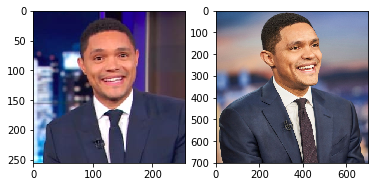

In [48]:
calc_dist_plot('2..jpg', '1..jpg')

C:\Users\karth\Anaconda3\envs\DL\lib\site-packages\scikit_image-0.14.2-py3.6-win-amd64.egg\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0.6239367127418518
verified... they are same person
-----------------------------------------


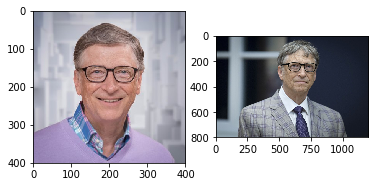

In [50]:
calc_dist_plot('Bill_Gates_0.jpg', 'Bill_Gates_0001.jpg')

C:\Users\karth\Anaconda3\envs\DL\lib\site-packages\scikit_image-0.14.2-py3.6-win-amd64.egg\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1.2589123249053955
unverified! they are not same person!
-----------------------------------------


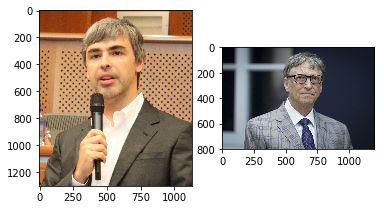

In [51]:
calc_dist_plot('Larry_Page_0.jpg', 'Bill_Gates_0001.jpg')

C:\Users\karth\Anaconda3\envs\DL\lib\site-packages\scikit_image-0.14.2-py3.6-win-amd64.egg\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1.459628939628601
unverified! they are not same person!
-----------------------------------------


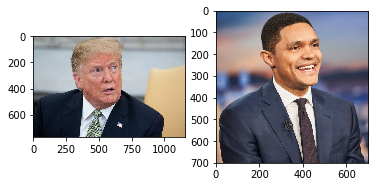

In [52]:
calc_dist_plot('y.jpg', '1..jpg')